<a href="https://colab.research.google.com/github/panahiparham/mlclass_proj_f2021/blob/main/Models/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

## KNN on Tox21

In [3]:
# dataset load
tox21_path = '/content/drive/MyDrive/Data Science @ SBU/Applied Machine Learning/project/tox21_preprocessed'
tox21_features = pd.read_csv(tox21_path + '/tox21_x.csv').to_numpy()
tox21_label = pd.read_csv(tox21_path + '/tox21_y.csv').to_numpy()

Tox21 features shape: (7237, 190) dtype: float64


Text(0.5, 1.0, 'range of features')

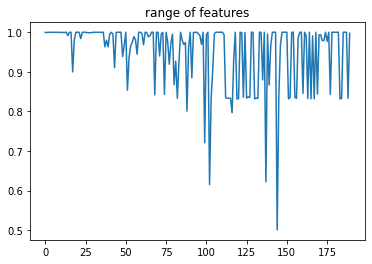

In [4]:
# exploring features
print('Tox21 features shape:', tox21_features.shape, 'dtype:', tox21_features.dtype)

feature_range = tox21_features.max(axis=0) - tox21_features.min(axis=0)
_ = plt.plot(feature_range)
plt.title('range of features')

In [5]:
# features are already scaled but serveral features are not in the [0, 1] range.
# they occupy a smaller range such as [0, 0.8]

In [6]:
# exploring labels
tox21_label = tox21_label.squeeze()
print('Tox21 features shape:', tox21_label.shape, 'dtype:', tox21_label.dtype)

num_pos_samples = np.count_nonzero(tox21_label)
print('Number of positive samples:', num_pos_samples)
print('Number of negative samples:', len(tox21_label) - num_pos_samples)

Tox21 features shape: (7237,) dtype: float64
Number of positive samples: 310
Number of negative samples: 6927


In [7]:
# labels are unbalanced, only a small portion of data is positive

In [8]:
# We start by training a baseline knn classfier, compare results of adding standardization and tuning
# scoring: roc-auc

In [9]:
# keep 20% of each class for final evaluation
x_train, x_test, y_train, y_test =  train_test_split(tox21_features, tox21_label , test_size=0.2, stratify=tox21_label, random_state = 42)

In [10]:
# baseline - knn

# cross validation on training set
model = KNeighborsClassifier()

cv = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# training on x_train

model = KNeighborsClassifier()
model.fit(x_train, y_train)

# testing on x_test
y_pred = model.predict(x_test)


print('Train Set Score:', roc_auc_score(y_train, model.predict_proba(x_train)[:,1]))
print('Cross Validation Score:', np.mean(cv_scores))
print('Test Set Score:', roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
print()

print('Training Confusion Matrix:')
print(confusion_matrix(y_train, model.predict(x_train)))
print()

print('Test Confusion Matrix:')
print(confusion_matrix(y_test, model.predict(x_test)))

Train Set Score: 0.9786125131716064
Cross Validation Score: 0.7635803621295845
Test Set Score: 0.6786470697761021

Training Confusion Matrix:
[[5526   15]
 [ 124  124]]

Test Confusion Matrix:
[[1380    6]
 [  42   20]]


In [11]:
# knn + standardization

# cross validation on training set
model = Pipeline(
    steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier())]
)

cv = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# training on x_train
model = Pipeline(
    steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier())]
)
model.fit(x_train, y_train)

# testing on x_test
y_pred = model.predict(x_test)


print('Train Set Score:', roc_auc_score(y_train, model.predict_proba(x_train)[:,1]))
print('Cross Validation Score:', np.mean(cv_scores))
print('Test Set Score:', roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
print()

print('Training Confusion Matrix:')
print(confusion_matrix(y_train, model.predict(x_train)))
print()

print('Test Confusion Matrix:')
print(confusion_matrix(y_test, model.predict(x_test)))

Train Set Score: 0.9777370743606313
Cross Validation Score: 0.752693945081524
Test Set Score: 0.6999778894940185

Training Confusion Matrix:
[[5524   17]
 [ 127  121]]

Test Confusion Matrix:
[[1380    6]
 [  40   22]]


In [12]:
# grid search

model = Pipeline(
    steps=[('scale',StandardScaler()),
           ('knn', KNeighborsClassifier())]
)

grid_params = {
    'knn__n_neighbors': [10,20,30,40,50],
    'knn__p': [1,2,3],
}

cv = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
grid = GridSearchCV(
    estimator = model,
    param_grid = grid_params,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = cv
)

grid_result = grid.fit(x_train, y_train)


# Report gridsearch result
print(f"Best score: {grid_result.best_score_} Best params: {grid_result.best_params_}")
print()
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print(f"score:{mean} params:{param}")

Best score: 0.809231288486657 Best params: {'knn__n_neighbors': 50, 'knn__p': 2}

score:0.7698988291413157 params:{'knn__n_neighbors': 10, 'knn__p': 1}
score:0.7728419306230206 params:{'knn__n_neighbors': 10, 'knn__p': 2}
score:0.7647727766636371 params:{'knn__n_neighbors': 10, 'knn__p': 3}
score:0.7843145576499572 params:{'knn__n_neighbors': 20, 'knn__p': 1}
score:0.7830571229667024 params:{'knn__n_neighbors': 20, 'knn__p': 2}
score:0.7755151380601852 params:{'knn__n_neighbors': 20, 'knn__p': 3}
score:0.7971473101035931 params:{'knn__n_neighbors': 30, 'knn__p': 1}
score:0.7905259231433114 params:{'knn__n_neighbors': 30, 'knn__p': 2}
score:0.786279611295352 params:{'knn__n_neighbors': 30, 'knn__p': 3}
score:0.7975977938352523 params:{'knn__n_neighbors': 40, 'knn__p': 1}
score:0.797570559709953 params:{'knn__n_neighbors': 40, 'knn__p': 2}
score:0.7907174138746917 params:{'knn__n_neighbors': 40, 'knn__p': 3}
score:0.805880576805501 params:{'knn__n_neighbors': 50, 'knn__p': 1}
score:0.809

In [13]:
# Tuned knn + standardization

# Best params: {'knn__n_neighbors': 50, 'knn__p': 2}

# cross validation on training set
model = Pipeline(
    steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=50, p=2))]
)

cv = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# training on x_train
model = Pipeline(
    steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=50, p=2))]
)
model.fit(x_train, y_train)

# testing on x_test
y_pred = model.predict(x_test)


print('Train Set Score:', roc_auc_score(y_train, model.predict_proba(x_train)[:,1]))
print('Cross Validation Score:', np.mean(cv_scores))
print('Test Set Score:', roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
print()

print('Training Confusion Matrix:')
print(confusion_matrix(y_train, model.predict(x_train)))
print()

print('Test Confusion Matrix:')
print(confusion_matrix(y_test, model.predict(x_test)))

Train Set Score: 0.8938459489669386
Cross Validation Score: 0.809231288486657
Test Set Score: 0.7231706465577433

Training Confusion Matrix:
[[5507   34]
 [ 138  110]]

Test Confusion Matrix:
[[1377    9]
 [  42   20]]


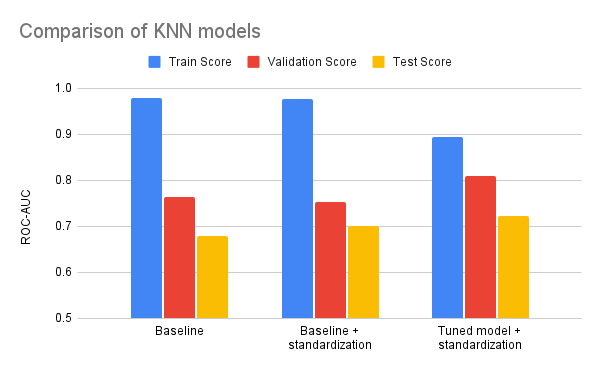

## KNN on TOXCAST

In [14]:
# data load
toxcast_data = pd.read_csv('/content/drive/MyDrive/Data Science @ SBU/Applied Machine Learning/project/toxcast_preprocessed/final_toxcast.csv')
toxcast_label = toxcast_data['label'].to_numpy()
toxcast_features = toxcast_data.drop(['label'], axis=1).to_numpy()

Tox21 features shape: (7831, 135) dtype: float64


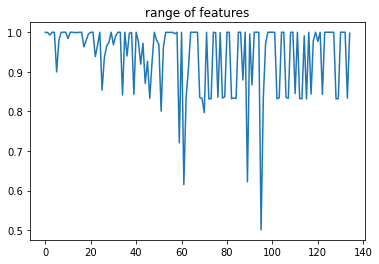

In [15]:
# exploring features
print('Tox21 features shape:', toxcast_features.shape, 'dtype:', toxcast_features.dtype)

feature_range = toxcast_features.max(axis=0) - toxcast_features.min(axis=0)
_ = plt.plot(feature_range)
_ = plt.title('range of features')

In [16]:
# features are already scaled but serveral features are not in the [0, 1] range.
# they occupy a smaller range such as [0, 0.8]

In [17]:
# exploring labels
print('Tox21 features shape:', toxcast_label.shape, 'dtype:', toxcast_label.dtype)

num_pos_samples = np.count_nonzero(toxcast_label)
print('Number of positive samples:', num_pos_samples)
print('Number of negative samples:', len(toxcast_label) - num_pos_samples)

Tox21 features shape: (7831,) dtype: float64
Number of positive samples: 1715
Number of negative samples: 6116


In [18]:
# keep 20% of each class for final evaluation
x_train, x_test, y_train, y_test =  train_test_split(toxcast_features, toxcast_label , test_size=0.2, stratify=toxcast_label, random_state = 42)

In [19]:
# baseline - knn

# cross validation on training set
model = KNeighborsClassifier()

cv = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# training on x_train

model = KNeighborsClassifier()
model.fit(x_train, y_train)

# testing on x_test
y_pred = model.predict(x_test)


print('Train Set Score:', roc_auc_score(y_train, model.predict_proba(x_train)[:,1]))
print('Cross Validation Score:', np.mean(cv_scores))
print('Test Set Score:', roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
print()

print('Training Confusion Matrix:')
print(confusion_matrix(y_train, model.predict(x_train)))
print()

print('Test Confusion Matrix:')
print(confusion_matrix(y_test, model.predict(x_test)))

Train Set Score: 0.9372854532538397
Cross Validation Score: 0.8098801890435796
Test Set Score: 0.8074837077688218

Training Confusion Matrix:
[[4699  193]
 [ 573  799]]

Test Confusion Matrix:
[[1133   91]
 [ 186  157]]


In [20]:
# knn + standardization

# cross validation on training set
model = Pipeline(
    steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier())]
)

cv = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# training on x_train
model = Pipeline(
    steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier())]
)
model.fit(x_train, y_train)

# testing on x_test
y_pred = model.predict(x_test)


print('Train Set Score:', roc_auc_score(y_train, model.predict_proba(x_train)[:,1]))
print('Cross Validation Score:', np.mean(cv_scores))
print('Test Set Score:', roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
print()

print('Training Confusion Matrix:')
print(confusion_matrix(y_train, model.predict(x_train)))
print()

print('Test Confusion Matrix:')
print(confusion_matrix(y_test, model.predict(x_test)))

Train Set Score: 0.9357434730112113
Cross Validation Score: 0.7987868039877384
Test Set Score: 0.8107766916290324

Training Confusion Matrix:
[[4721  171]
 [ 609  763]]

Test Confusion Matrix:
[[1145   79]
 [ 193  150]]


In [21]:
# grid search

model = Pipeline(
    steps=[('scale',StandardScaler()),
           ('knn', KNeighborsClassifier())]
)

grid_params = {
    'knn__n_neighbors': [10,20,30,40,50],
    'knn__p': [1,2,3],
}

cv = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
grid = GridSearchCV(
    estimator = model,
    param_grid = grid_params,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = cv
)

grid_result = grid.fit(x_train, y_train)


# Report gridsearch result
print(f"Best score: {grid_result.best_score_} Best params: {grid_result.best_params_}")
print()
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print(f"score:{mean} params:{param}")

Best score: 0.8382481501314599 Best params: {'knn__n_neighbors': 20, 'knn__p': 1}

score:0.8297247368868916 params:{'knn__n_neighbors': 10, 'knn__p': 1}
score:0.8138764171494935 params:{'knn__n_neighbors': 10, 'knn__p': 2}
score:0.7980531571095341 params:{'knn__n_neighbors': 10, 'knn__p': 3}
score:0.8382481501314599 params:{'knn__n_neighbors': 20, 'knn__p': 1}
score:0.8203811491319957 params:{'knn__n_neighbors': 20, 'knn__p': 2}
score:0.7956514923494439 params:{'knn__n_neighbors': 20, 'knn__p': 3}
score:0.8324949153363133 params:{'knn__n_neighbors': 30, 'knn__p': 1}
score:0.8156129461302246 params:{'knn__n_neighbors': 30, 'knn__p': 2}
score:0.7885480505052385 params:{'knn__n_neighbors': 30, 'knn__p': 3}
score:0.8274028944557454 params:{'knn__n_neighbors': 40, 'knn__p': 1}
score:0.813313540830505 params:{'knn__n_neighbors': 40, 'knn__p': 2}
score:0.7822587078640251 params:{'knn__n_neighbors': 40, 'knn__p': 3}
score:0.824633953828695 params:{'knn__n_neighbors': 50, 'knn__p': 1}
score:0.8

In [22]:
# Tuned knn + standardization

# Best params: {'knn__n_neighbors': 20, 'knn__p': 1}
model = Pipeline(
    steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=20, p=1))]
)

cv = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# training on x_train
model = Pipeline(
    steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=20, p=1))]
)
model.fit(x_train, y_train)

# testing on x_test
y_pred = model.predict(x_test)


print('Train Set Score:', roc_auc_score(y_train, model.predict_proba(x_train)[:,1]))
print('Cross Validation Score:', np.mean(cv_scores))
print('Test Set Score:', roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
print()

print('Training Confusion Matrix:')
print(confusion_matrix(y_train, model.predict(x_train)))
print()

print('Test Confusion Matrix:')
print(confusion_matrix(y_test, model.predict(x_test)))

Train Set Score: 0.8866962244540381
Cross Validation Score: 0.8382481501314599
Test Set Score: 0.8347422302254235

Training Confusion Matrix:
[[4791  101]
 [ 940  432]]

Test Confusion Matrix:
[[1180   44]
 [ 236  107]]


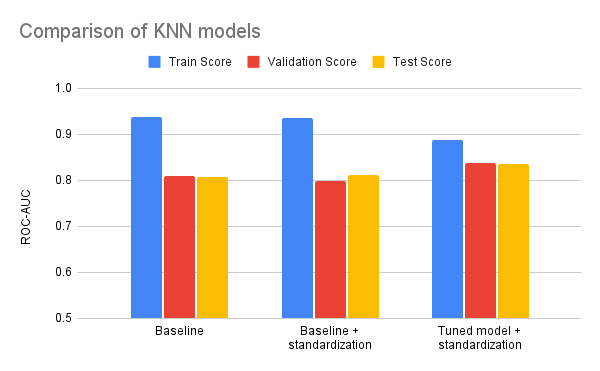

KNN on QM9

In [26]:
# import data
qm9_features = np.load('/content/drive/MyDrive/Data Science @ SBU/Applied Machine Learning/project/qm9_preprocessed/qm9_features.npy')
qm9_labels_df = pd.read_csv('/content/drive/MyDrive/Data Science @ SBU/Applied Machine Learning/project/qm9_preprocessed/qm9_labels.csv')

In [27]:
# selecting 'gap' task
gap_labels = qm9_labels_df['gap'].to_numpy()
print('features shape:', qm9_features.shape)
print('labels shape:', gap_labels.shape)

features shape: (133885, 163)
labels shape: (133885,)


In [35]:
# train/test split (random split 0.1)
x_train, x_test, y_train, y_test =  train_test_split(qm9_features, gap_labels , test_size=0.9, random_state=42)

In [36]:
# train on x_train
model = KNeighborsRegressor().fit(x_train, y_train)

# score on x_train
print('Train MAE score:', mean_absolute_error(y_train,model.predict(x_train)))
print('Train r2 score:', model.score(x_train, y_train))
print()
# score on x_test
print('Test MAE score:', mean_absolute_error(y_test,model.predict(x_test)))
print('Test r2 score:', model.score(x_test, y_test))

Train MAE score: 0.011240582611293697
Train r2 score: 0.8799033735358975

Test MAE score: 0.014297667493796526
Test r2 score: 0.8070517865560219


In [37]:
# Normalizing labels
y_scale = StandardScaler()

y_train_scaled = y_scale.fit_transform(y_train.reshape(-1,1)).squeeze()
y_test_scaled = y_scale.transform(y_test.reshape(-1,1)).squeeze()

In [38]:
# feature pipeline
pipe = Pipeline(
    steps=[
           ('scale', StandardScaler()),
           ('pca', PCA(n_components = 0.9)),
           ('knn', KNeighborsRegressor())
    ]
)

# label scaler
y_scale = StandardScaler()

y_train_scaled = y_scale.fit_transform(y_train.reshape(-1,1)).squeeze()
y_test_scaled = y_scale.transform(y_test.reshape(-1,1)).squeeze()

In [39]:
# train on x_train
model = pipe.fit(x_train, y_train_scaled)

y_pred_train = model.predict(x_train)
y_pred_test  = model.predict(x_test)

In [40]:
# inverse transform to get comparable MAE
y_pred_train = y_scale.inverse_transform(y_pred_train.reshape(-1,1)).squeeze()
y_pred_test = y_scale.inverse_transform(y_pred_test.reshape(-1,1)).squeeze()


# score on x_train
print('Train MAE score:', mean_absolute_error(y_train,y_pred_train))
print('Train r2 score:', model.score(x_train, y_train_scaled))
print()
# score on x_test
print('Test MAE score:', mean_absolute_error(y_test,y_pred_test))
print('Test r2 score:', model.score(x_test, y_test_scaled))

Train MAE score: 0.010648610696145804
Train r2 score: 0.8967904631737066

Test MAE score: 0.013522642389437081
Test r2 score: 0.8323217076046127


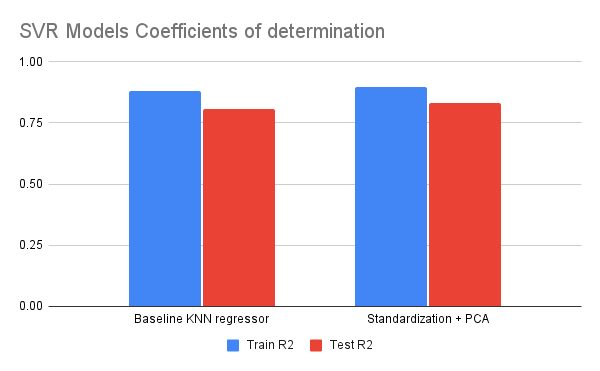

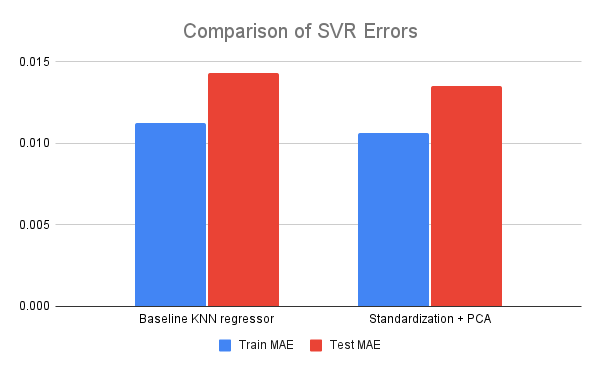